In [1]:
## import for plotting
%matplotlib inline
from os import listdir
from os.path import isfile, join
import numpy as np
from glob import glob
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from adjustText import adjust_text

## import for stats
import statsmodels.stats.multitest as smt
from scipy import stats
from collections import defaultdict

In [79]:
## import for PDB manipulation
from Bio import PDB
from Bio.PDB import PDBParser
from Bio.PDB import PDBIO

### Compute distance between MT-encoded proteins (chain M) and nuclear-encoded proteins (chain N)

In [62]:
def get_pdb_structure(pdb_file):
    ### Load the PDB file
    
    pdb_parser = PDB.PDBParser(QUIET=True)
    structure = pdb_parser.get_structure('protein', pdb_file)
    return structure

In [63]:
def calculate_distance(coord1, coord2):
    ### Function to calculate distance between two points
    return np.linalg.norm(coord1 - coord2)

In [82]:
dir_path = '/Users/osipova/Documents/LabDocs/Brood_parasites_analysis/NAD_complex_structure/'
pdb_file = 'complex_I_anoImb_M_N_ddN.pdb'
structure = get_pdb_structure(dir_path + pdb_file)

## Save structure
# pdb_io = PDBIO()
# pdb_io.set_structure(structure)
# pdb_io.save('renumbered_pdb_file.pdb')

In [83]:
# Select chains M and N
chain_M = structure[0]['M']
chain_N = structure[0]['N']

# Extract CA atoms and their residue IDs for all residues in each chain
ca_atoms_M = [(residue['CA'], f"{residue.resname}_{residue.id[1]}") 
              for residue in chain_M if 'CA' in residue]
ca_atoms_N = [(residue['CA'], f"{residue.resname}_{residue.id[1]}") 
              for residue in chain_N if 'CA' in residue]

# Initialize a distance matrix
distance_matrix = np.zeros((len(ca_atoms_N), len(ca_atoms_M)))

# Fill the matrix with distances and keep track of residue IDs
for i, (atom_N, res_id_N) in enumerate(ca_atoms_N):
    for j, (atom_M, res_id_M) in enumerate(ca_atoms_M):
        distance_matrix[i, j] = calculate_distance(atom_N.coord, atom_M.coord)

# Collect residue IDs for easy reference
residues_M = [res_id_M for _, res_id_M in ca_atoms_M]
residues_N = [res_id_N for _, res_id_N in ca_atoms_N]

# Convert the distance matrix to a pandas DataFrame with residue IDs as row/column labels
distance_df = pd.DataFrame(distance_matrix, index=residues_N, columns=residues_M)
distance_df.head()

,MET_1,THR_2,ASN_3,HIS_4,PRO_5,MET_6,LEU_7,ILE_8,ASN_9,LEU_10,...,SER_596,ILE_597,THR_598,ILE_599,ILE_600,LEU_601,ILE_602,SER_603,THR_604,TYR_605
MET_1,55.015274,55.009197,52.996067,51.425522,49.828991,48.470726,46.577038,45.151386,44.115421,42.570705,...,86.368889,84.627998,85.775063,89.358223,89.294891,88.083916,90.831619,93.450592,92.621605,94.201324
TRP_2,53.039963,53.042133,50.843788,49.352093,47.541759,46.303802,44.590931,42.973400,41.779293,40.470440,...,83.606407,81.779984,82.989319,86.575142,86.398453,85.168655,87.985397,90.550194,89.623459,91.222847
TYR_3,50.068611,50.226425,48.150162,46.791748,45.124886,44.026363,42.113728,40.424622,39.491623,38.216492,...,83.546997,81.615669,82.684021,86.332222,86.177780,84.788071,87.547981,90.202751,89.228249,90.682487
GLU_4,49.026562,48.977764,47.018196,45.423580,43.920033,42.553505,40.569477,39.192017,38.259724,36.649460,...,82.326721,80.500244,81.463814,85.113510,85.124199,83.748260,86.402885,89.141243,88.312645,89.731323
ILE_5,46.746826,46.599575,44.443596,42.827477,41.108440,39.758141,37.992359,36.513149,35.347801,33.884232,...,78.777939,76.904060,77.905334,81.555893,81.504662,80.123787,82.818848,85.524879,84.649200,86.087006


### Get min distance from each nuclear residue to MT residues

In [84]:
min_values_info = []

for row_id, row_data in distance_df.iterrows():
    # Find the column (MT residue) with the minimum value in this row
    min_col = row_data.idxmin()
    min_value = row_data.min()
    min_values_info.append((row_id, min_col, min_value))

min_values_df = pd.DataFrame(min_values_info, columns=['N_Residue', 'Min_M_Residue', 'Min_Distance'])

### Assign ddN (delta dN (Vmac - Aimb)) to each nulear residue

In [85]:
def extract_b_factors(structure, chain_id):
    ### Function to extract the B-factors for the CA atoms in chain M
    
    chain = structure[0][chain_id]
    
    ### Extract B-factors for each residue in the chain (from CA atoms)
    b_factors = {}
    for residue in chain:
        if 'CA' in residue:  # Use CA atoms to be consistent
            res_id = f"{residue.resname}_{residue.id[1]}"
            b_factors[res_id] = residue['CA'].get_bfactor()
    return b_factors

In [86]:
# Extract B-factors for chain N (nuclear residues)
b_factors_M = extract_b_factors(structure, 'N')
min_values_df['ddN'] = min_values_df['N_Residue'].map(b_factors_M)

### Is this AA unique in Aimb? Assign BEB (True or False in this case) values to each nuclear residue

In [87]:
pdb_file = 'complex_I_anoImb_M_N_BEB.pdb'
structure2 = get_pdb_structure(dir_path + pdb_file)

# Extract B-factors for chain N (nuclear residues)
b_factors_M = extract_b_factors(structure2, 'N')
min_values_df['BEB'] = min_values_df['N_Residue'].map(b_factors_M)

### Write this table to a file

In [88]:
min_values_df.to_csv('distances_complex_I_anoImb.tsv', sep='\t', index=False)

In [50]:
### Any correlation between ddN and distance?

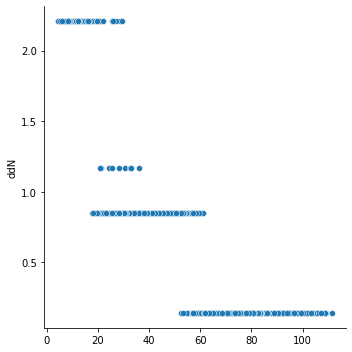

In [53]:
fig, axes = plt.subplots(figsize=(5, 5))

sns.scatterplot(data=min_values_df, x='Min_Distance', y='ddN')
# axes.set_xlabel('')

sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

In [89]:
min_values_df[min_values_df['BEB']!=0]

,N_Residue,Min_M_Residue,Min_Distance,ddN,BEB
55,ALA_56,MET_1,16.347404,2.21,1.0
85,ILE_86,ASP_290,45.971004,0.85,1.0
94,PHE_95,ALA_326,39.649700,0.85,1.0
111,LEU_112,ALA_326,35.120956,0.85,1.0
115,LYS_116,ALA_326,33.576454,0.85,1.0
127,THR_128,HIS_422,45.223335,0.85,1.0
142,TRP_143,ALA_326,33.969391,0.85,1.0
193,ASP_194,GLY_584,36.095875,0.85,1.0
202,SER_203,ALA_326,31.257509,0.85,1.0
323,PRO_324,MET_572,35.877979,0.85,1.0
